In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [3]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [4]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

[ Info: Precompiling PhasorNetworks [c32d742c-e486-48f1-8804-9f6fb4d3f42c] (cache misses: include_dependency fsize change (2), mismatched flags (12))


In [5]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [6]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [7]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing}) (generic function with 1 method)

In [8]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 10
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2])

@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 256    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
    rng::Xoshiro = Xoshiro(42) ## global rng
end

Args

In [9]:
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [10]:
import .PhasorNetworks: v_bundle_project, neuron_constant, spike_current, bias_current, gaussian_kernel, is_active

In [11]:
args = Args(use_cuda = true)

Args(0.0003, 256, 10, true, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [12]:
model = Chain(Dense(1=>20, relu), Dense(20=>1))
ps, st = Lux.setup(Xoshiro(42), model) .|> gdev
x = rand(Float32, 1, 50) |> gdev
y = model(x, ps, st)  # Check for errors here

(Float32[-0.39962012 -0.37769175 … -0.33028084 -0.31575269], (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [13]:
train_loader, test_loader = getdata(args)
x, y = first(train_loader)

(Float32[0.43635908 -0.02072694 … -0.014802111 -0.0019893101; -0.17784306 0.30380124 … -0.07276908 -0.0056274263], Bool[0 0 … 1 1; 1 1 … 0 0])

In [14]:
#test that norm layers are working
model = Chain(BatchNorm(2), Dense(2=>20, relu),  Dense(20=>10),)
ps, st = Lux.setup(Xoshiro(42), model) .|> gdev

((layer_1 = (scale = Float32[1.0, 1.0], bias = Float32[0.0, 0.0]), layer_2 = (weight = Float32[-0.22298728 0.46045378; -1.5991516 0.21926863; … ; -0.8419455 0.6898169; -1.9868723 -2.060835], bias = Float32[0.11489113, 0.6639945, -0.4025346, -0.6888659, -0.4826754, 0.3613354, 0.48929778, -0.21674016, -0.0905359, -0.19842264, -0.70039135, -0.3391459, 0.69077945, 0.6395895, -0.14078076, -0.61794806, 0.6431609, -0.4320272, -0.5562653, 0.6559268]), layer_3 = (weight = Float32[-0.36478028 -0.35009816 … 0.16633585 -0.09001794; 0.11778823 0.23967978 … 0.16875134 0.2501211; … ; 0.18630779 0.37657124 … -0.22133704 0.3819737; -0.28481823 -0.016084503 … 0.33211577 -0.015221041], bias = Float32[-0.08397981, -0.14111775, 0.0053543923, 0.13371398, -0.19779338, -0.114208594, 0.19246913, -0.20375684, -0.072584175, 0.020619141])), (layer_1 = (running_mean = Float32[0.0, 0.0], running_var = Float32[1.0, 1.0], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

In [15]:
model(x |> gdev, ps, st)

┌ Warning: `training` is set to `Val{true}()` but is not being used within an autodiff call (gradient, jacobian, etc...). This will be slow. If you are using a `Lux.jl` model, set it to inference (test) mode using `LuxCore.testmode`. Reliance on this behavior is discouraged, and is not guaranteed by Semantic Versioning, and might be removed without a deprecation cycle. It is recommended to fix this issue in your code.
└ @ LuxLib.Utils ~/.julia/packages/LuxLib/kH9PB/src/utils.jl:314


(Float32[-1.6251575 -1.3643706 … -1.0334208 -0.8540355; -1.4790964 -0.66562456 … 0.3910789 0.16788703; … ; 0.36006203 0.19507381 … 1.1235024 0.82358015; -0.7144655 -0.43026197 … 0.4476107 0.1147916], (layer_1 = (running_mean = Float32[0.0017730048, 0.00067927514], running_var = Float32[0.9039085, 0.90418065], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

# Test FP32

In [16]:
function build_mlp(args)
    phasor_model = Chain(LayerNorm((2,)), x -> tanh.(x), x -> x, PhasorDense(2 => 128), PhasorDense(128 => 2))
    ps, st = Lux.setup(args.rng, phasor_model)
    return phasor_model, ps, st
end

build_mlp (generic function with 1 method)

In [17]:
x = x |> gdev

2×256 CuArray{Float32, 2, CUDA.DeviceMemory}:
  0.436359  -0.0207269   0.0444016  -0.0051785   …  -0.0148021  -0.00198931
 -0.177843   0.303801   -0.0365956  -0.00554021     -0.0727691  -0.00562743

In [18]:
size(x)

(2, 256)

In [19]:
model_f, ps_f, st_f = build_mlp(args)

(Chain{@NamedTuple{layer_1::LayerNorm{Tuple{Int64}, typeof(identity), Float32, typeof(zeros32), typeof(ones32), Colon, Static.True}, layer_2::WrappedFunction{var"#33#35"}, layer_3::WrappedFunction{var"#34#36"}, layer_4::PhasorDense, layer_5::PhasorDense}, Nothing}((layer_1 = LayerNorm((2,), affine=true, dims=Colon()), layer_2 = WrappedFunction(#33), layer_3 = WrappedFunction(#34), layer_4 = PhasorDense((2, 128)), layer_5 = PhasorDense((128, 2))), nothing), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.025199654 0.005086061; 0.021546587 -0.11127125; … ; 0.15865159 -0.030458387; -0.24032864 0.049523916], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_5 = (weight = Float32[0.12666641 

In [20]:
ps_f = ps_f |> gdev
st_f = st_f |> gdev

(layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple())

In [21]:
y_f, _ = model_f(x, ps_f, st_f) 

(Float32[-0.020149658 0.045700043 … 0.014530507 0.011981527; -0.02249537 -0.00995539 … -0.054838575 -0.023126202], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [22]:
y_f |> typeof

CuArray{Float32, 2, CUDA.DeviceMemory}

In [23]:
size(y_f)

(2, 256)

In [24]:
losses_f, ps_train_f, st_train_f = train(model_f, ps_f, st_f, train_loader, args)

[ Info: Training on CUDA GPU


(Any[0.4987212113809998, 0.521122191794009, 0.5082742479009222, 0.5136231814811849, 0.49438453474908484, 0.4974023651358642, 0.4872463278624626, 0.4812212228282078, 0.48914629215988037, 0.48157892148610654  …  0.05532420755450476, 0.043126595831990286, 0.043077381269434736, 0.04251557404212223, 0.059209086565330415, 0.04838971455472543, 0.05391948963310008, 0.05201482573252102, 0.0604854485165138, 0.04945148768182123], (layer_1 = (bias = Float32[-0.19326492; -0.1934431;;], scale = Float32[0.8069064; 0.7923898;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.041125026 0.010296932; 0.0069805593 -0.09867007; … ; 0.15147264 -0.017196883; -0.24489555 0.021723168], bias_real = Float32[0.98994374, 1.0200062, 1.0263494, 0.98612386, 0.86550725, 0.973798, 0.97416484, 0.9831198, 0.9938522, 0.973759  …  0.98657197, 1.0009376, 1.0316812, 1.0203657, 0.9861856, 1.0052575, 0.98179805, 0.9936021, 1.0099664, 0.9952298], bias_imag = Float32[-0.0047133034, -0.003984232, 0

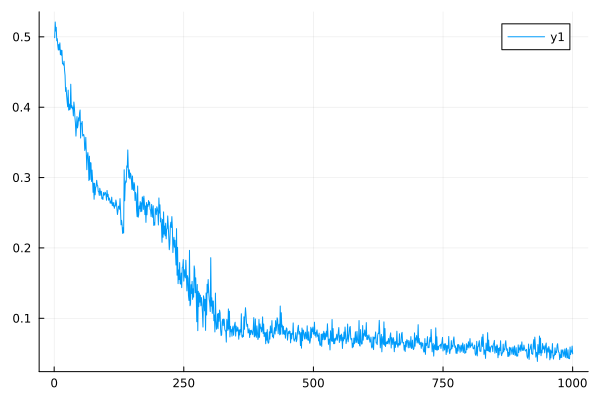

In [25]:
plot(losses_f)

In [26]:
import .PhasorNetworks: loss_and_accuracy, SpikingTypes

In [27]:
args.use_cuda

true

In [28]:
yfc = y_f |> cdev

2×256 Matrix{Float32}:
 -0.0201497   0.0457      -0.0682223    0.0168105  …   0.0145305   0.0119815
 -0.0224954  -0.00995539  -0.00617258  -0.0253506     -0.0548386  -0.0231262

In [29]:
loss_and_accuracy(test_loader, model_f, ps_train_f |> gdev, st_train_f |> gdev, args)

(0.0501451900814048, 0.98203125)

In [30]:
ps_train_f.layer_1

(bias = Float32[-0.19326492; -0.1934431;;], scale = Float32[0.8069064; 0.7923898;;])

In [31]:
yt_f, _ = model_f(x, ps_train_f, st_train_f)

(Float32[-0.06825633 0.104416214 … 0.50418824 0.556367; 0.3852908 0.41843346 … 0.12666069 0.03351757], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

# Test spiking behavior

In [32]:
function build_spiking_mlp(args, spk_args)
    spk_model = Chain(LayerNorm((2,)), 
                    x -> tanh.(x),
                    MakeSpiking(spk_args, repeats),
                    PhasorDense(2 => 128), #return_solution=true),)
                    PhasorDense(128 => 2),)
    ps, st = Lux.setup(args.rng, spk_model)
    return spk_model, ps, st
end

build_spiking_mlp (generic function with 1 method)

In [33]:
spk_model_f, ps_spk, st_spk = build_spiking_mlp(args, spk_args)

(Chain{@NamedTuple{layer_1::LayerNorm{Tuple{Int64}, typeof(identity), Float32, typeof(zeros32), typeof(ones32), Colon, Static.True}, layer_2::WrappedFunction{var"#37#38"}, layer_3::MakeSpiking, layer_4::PhasorDense, layer_5::PhasorDense}, Nothing}((layer_1 = LayerNorm((2,), affine=true, dims=Colon()), layer_2 = WrappedFunction(#37), layer_3 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 10, (0.0, 10.0f0), 0.0), layer_4 = PhasorDense((2, 128)), layer_5 = PhasorDense((128, 2))), nothing), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.27116936 0.0861502; -0.07204794 -0.15312071; … ; -0.039547402 -0.030699156; 0.003936669 -0.020530548], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.

In [34]:
ps_spk = ps_spk |> gdev
st_spk = st_spk |> gdev

(layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple())

In [35]:
import .PhasorNetworks: phase_to_train

In [36]:
xt, yt = first(train_loader)

(Float32[0.43635908 -0.02072694 … -0.014802111 -0.0019893101; -0.17784306 0.30380124 … -0.07276908 -0.0056274263], Bool[0 0 … 1 1; 1 1 … 0 0])

In [37]:
ts = phase_to_time(x, spk_args=spk_args, offset=0.0f0)

2×256 CuArray{Float32, 2, CUDA.DeviceMemory}:
 0.71818   0.489637  0.522201  0.497411  …  0.503094  0.492599  0.499005
 0.411078  0.651901  0.481702  0.49723      0.498118  0.463615  0.497186

In [38]:
import .PhasorNetworks: phase_to_train

In [39]:
a = phase_to_train(x, spk_args=spk_args, repeats=10, offset=0.0f0)

SpikeTrainGPU(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(1, 2), CartesianIndex(2, 2), CartesianIndex(1, 3), CartesianIndex(2, 3), CartesianIndex(1, 4), CartesianIndex(2, 4), CartesianIndex(1, 5), CartesianIndex(2, 5)  …  CartesianIndex(1, 252), CartesianIndex(2, 252), CartesianIndex(1, 253), CartesianIndex(2, 253), CartesianIndex(1, 254), CartesianIndex(2, 254), CartesianIndex(1, 255), CartesianIndex(2, 255), CartesianIndex(1, 256), CartesianIndex(2, 256)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  503, 504, 505, 506, 507, 508, 509, 510, 511, 512], Float32[0.7181795, 0.41107845, 0.48963654, 0.65190065, 0.5222008, 0.48170218, 0.49741074, 0.4972299, 0.46343565, 0.50226045  …  9.315895, 9.582314, 9.510534, 9.509322, 9.503094, 9.498118, 9.492599, 9.463615, 9.499005, 9.497187], (2, 256), 512, 0.0f0)

In [40]:
import .PhasorNetworks: gaussian_kernel_gpu

In [41]:
spk_args.t_window

0.01f0

In [42]:
y_spk_f, _ = spk_model_f(x, ps_train_f, st_train_f)

(SpikingCall(SpikeTrainGPU(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(1, 2), CartesianIndex(2, 2), CartesianIndex(1, 3), CartesianIndex(2, 3), CartesianIndex(1, 4), CartesianIndex(2, 4), CartesianIndex(1, 5), CartesianIndex(2, 5)  …  CartesianIndex(1, 252), CartesianIndex(2, 252), CartesianIndex(1, 253), CartesianIndex(2, 253), CartesianIndex(1, 254), CartesianIndex(2, 254), CartesianIndex(1, 255), CartesianIndex(2, 255), CartesianIndex(1, 256), CartesianIndex(2, 256)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  503, 504, 505, 506, 507, 508, 509, 510, 511, 512], Float32[2.0004747, 1.999689, 2.0004747, 1.999689, 2.0004747, 1.999689, 2.0004747, 1.999689, 2.0004747, 1.999689  …  11.018522, 11.112172, 11.1822, 10.992664, 11.182129, 11.01507, 11.110584, 11.056267, 11.173596, 11.015751], (2, 256), 512, 0.5f0), Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0f0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), la

In [43]:
typeof(y_spk_f)

SpikingCall

In [44]:
y_spk_f.train.offset

0.5f0

In [45]:
p_spk_f = train_to_phase(y_spk_f)

11×2×256 Array{Float64, 3}:
[:, :, 1] =
 NaN           -0.000622034
  -0.0043149  NaN
  -0.0100465    0.0365834
  -0.0161734    0.0766659
  -0.0225983    0.117749
  -0.0292034    0.157705
  -0.0358543    0.194693
  -0.0424137    0.227531
  -0.0487537    0.255772
  -0.0508575    0.279514
 NaN            0.328592

[:, :, 2] =
 NaN             -0.000622034
   0.000949383  NaN
   0.00657892     0.0200629
   0.0125208      0.0443172
   0.018671       0.0721798
   0.02491        0.103325
   0.0311079      0.136961
   0.0371399      0.171854
   0.0428944      0.206514
  -0.984653       0.239504
 NaN              0.0211067

[:, :, 3] =
 NaN             -0.000622034
   0.000949383   -0.000227928
   0.0253577    NaN
   0.0540743      0.000178337
   0.0870275      0.000590324
   0.123581       0.000998497
   0.162445       0.00139618
   0.201811       0.00177574
   0.239752       0.00213051
   0.274675       0.00246239
   0.310106       0.0213623

;;; … 

[:, :, 254] =
 NaN             -0.0006220

In [46]:
spkt = y_spk_f.train.times |> cdev

5120-element Vector{Float32}:
  2.0004747
  1.999689
  2.0004747
  1.999689
  2.0004747
  1.999689
  2.0004747
  1.999689
  2.0004747
  1.999689
  2.0004747
  1.999689
  2.0004747
  ⋮
 11.000995
 11.154528
 11.018522
 11.112172
 11.1822
 10.992664
 11.182129
 11.01507
 11.110584
 11.056267
 11.173596
 11.015751

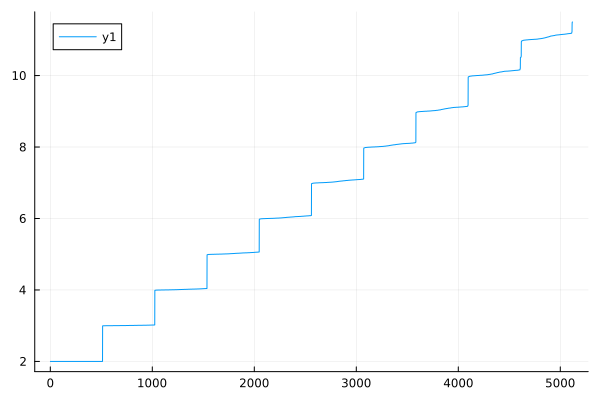

In [47]:
plot(sort(spkt))

In [48]:
y_f |> size

(2, 256)

In [49]:
size(p_spk_f)

(11, 2, 256)

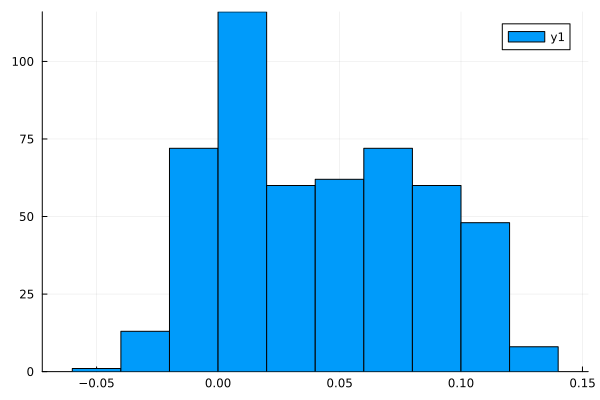

In [50]:
histogram(vec(p_spk_f[5,:,:]))

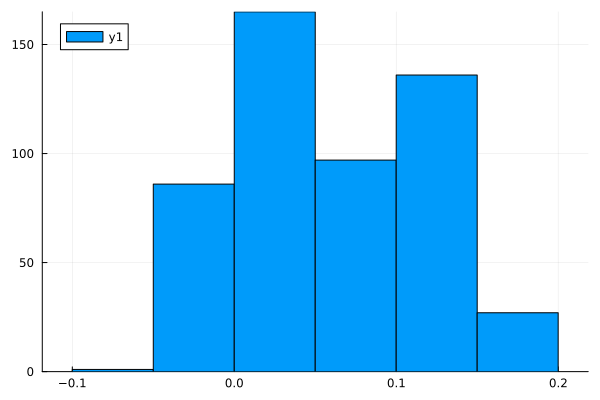

In [51]:
histogram(vec(p_spk_f[6,:,:]))

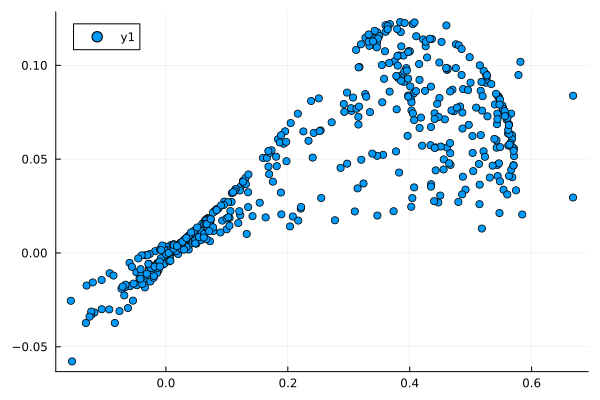

In [52]:
scatter(vec(yt_f |> cdev), vec(p_spk_f[5,:,:]))

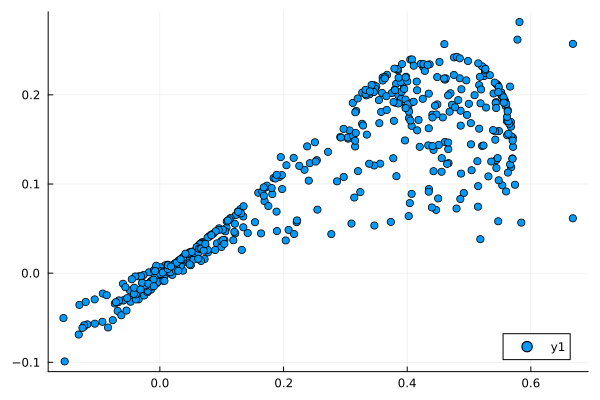

In [53]:
scatter(vec(yt_f |> cdev), vec(p_spk_f[8,:,:]))

In [54]:
cycle_correlation(yt_f |> cdev, p_spk_f)

11-element Vector{Float64}:
 NaN
   0.571049176670598
   0.7487408550070387
   0.7681527343148609
   0.7960903543279537
   0.8256166244698042
   0.8542799074254058
   0.8818298370023214
   0.9059856005065393
   0.6226303893967978
   0.6899240726078065

In [55]:
test_loader

10-element Vector{Tuple{Matrix{Float32}, OneHotMatrix{UInt32, Vector{UInt32}}}}:
 ([-0.08691765 -0.16325024 … 0.21662244 0.013724993; -0.35891506 -0.2634432 … -0.055286564 -0.3696492], [0 0 … 0 0; 1 1 … 1 1])
 ([0.0089486595 0.37673405 … -0.31594756 -0.0058631464; -0.034340538 0.19114222 … -0.37602445 0.004518437], [1 0 … 0 1; 0 1 … 1 0])
 ([-0.0009634143 -0.016934637 … 0.014787699 -0.22533846; -0.0027232713 0.039792404 … -0.009913963 -0.31259555], [1 1 … 1 0; 0 0 … 0 1])
 ([-0.0012602282 -0.03544415 … 0.41275188 0.016422918; -0.00016874271 -0.28314772 … -0.047115732 0.023927195], [1 0 … 0 1; 0 1 … 1 0])
 ([0.36031964 -0.027941216 … -0.059818305 0.12108625; 0.04160081 -0.009401257 … 0.41710234 0.29667535], [0 1 … 0 0; 1 0 … 1 1])
 ([0.4197457 -0.19090953 … -0.15805289 0.07350707; -0.2042147 0.26834553 … -0.46646586 0.16907275], [0 0 … 0 1; 1 1 … 1 0])
 ([0.3751181 0.0053411266 … -0.1364882 0.40595627; -0.08361959 -0.028051462 … -0.30387133 0.2468076], [0 1 … 0 0; 1 0 … 1 1])
 ([0.04917

In [56]:
import .PhasorNetworks: spiking_accuracy, accuracy_quadrature, on_gpu

In [57]:
spk_acc = spiking_accuracy(test_loader, spk_model_f, ps_train_f, st_train_f, args, 10)

10×1 Matrix{Float64}:
 0.91953125
 0.942578125
 0.93515625
 0.943359375
 0.916796875
 0.94453125
 0.92890625
 0.925
 0.917578125
 0.92265625

In [58]:
stop

LoadError: UndefVarError: `stop` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [ ]:
function dense_onehot(x::OneHotMatrix)
    return 1.0f0 .* x
end

dense_onehot (generic function with 1 method)

In [ ]:
function accuracy_quadrature(phases::AbstractMatrix, truth::AbstractMatrix)
    if on_gpu(phases, truth)
        phases = phases |> cdev
        truth = truth |> cdev
    end

    predictions = predict_quadrature(phases)
    labels = getindex.(findall(truth .== 1.0f0), 1)
    return predictions .== labels
end

function accuracy_quadrature(phases::Array{<:Real,3}, truth::AbstractMatrix)
    if on_gpu(phases, truth)
        phases = phases |> cdev
        truth = truth |> cdev
    end

    return [accuracy_quadrature(phases[i,:,:], truth) for i in axes(phases,1)]
end

accuracy_quadrature (generic function with 2 methods)

In [ ]:
function spiking_accuracy(data_loader, model, ps, st, args, repeats::Int)
    acc = []
    n_phases = []
    num = 0

    for (x, y) in data_loader
        if args.use_cuda
            x = x |> gdev
            y = y |> dense_onehot |> gdev
        end
        
        spk_output, _ = model(x, ps, st)
        ŷ = train_to_phase(spk_output)
        
        append!(acc, sum.(accuracy_quadrature(ŷ, y))) ## Decode the output of the model
        num += size(x)[end]
    end

    acc = sum(reshape(acc, repeats, :), dims=2) ./ num
    return acc
end


spiking_accuracy (generic function with 1 method)